# Fitting a quadriatic form
Here lets consider the problem of optimizing elements of a coefficient matrix $A$ that generates a polynomial through a quadriatic form:
$$Q(x) \equiv y^T A y = ax^2 + 2bx + c$$
where 
$$ A \equiv \begin{bmatrix}
a & b/2 \\
b/2 & c \\
\end{bmatrix}
\quad 
y \equiv \begin{bmatrix} x & 1 \end{bmatrix}^T
$$

In [378]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [388]:
# w = torch.linspace(0,1,41,dtype=torch.float64) # for plotting
w = torch.linspace(0,1,101,dtype=torch.complex128) # for plotting
# parameters_ideal = torch.tensor([1,2.5,-2],dtype=torch.float64)
parameters_ideal = torch.tensor([1,2,3.1],dtype=torch.float64)
parameters = torch.tensor([0,0,4],dtype=torch.float64,requires_grad=True)

def computeValues(parameters, w):
    L1,C1,G1 = parameters

    # Efficiently compute components of the matrix
    top_left = 1 - L1 * C1 * (w**2)       # 1 + a * (x^2)
    top_right = 1j*L1 * w               # b * x
    bottom_left = G1+1j*C1 * w             # c * x
    bottom_right = torch.ones_like(w)  # Constant 1

    # Q = top_left/bottom_left
    
    # Stack the components into a 3D tensor
    matrix_tensor = torch.stack([
        torch.stack([top_left, top_right], dim=-1),    # Row 1 of each matrix
        torch.stack([bottom_left, bottom_right], dim=-1)  # Row 2 of each matrix
    ], dim=-2)  # Combine rows into a matrix
    
    Q = matrix_tensor[:,0,0]/matrix_tensor[:,1,0]
    return Q

def computeError(parameters):
    polynomial_w = computeValues(parameters,w)
    polynomial_target = computeValues(parameters_ideal,w)
    # loss_real = torch.nn.MSELoss()(torch.real(polynomial_w), torch.real(polynomial_target))
    # loss_imag = nn.MSELoss()(torch.imag(polynomial_w), torch.real(polynomial_target))
    # loss = loss_real+loss_imag
    loss = torch.nn.MSELoss()(polynomial_w,polynomial_target)
    return loss

Iteration 60 : tensor([ 9.7581, 20.7170,  3.0704], dtype=torch.float64, requires_grad=True);  f = 0.0625498480222585
Iteration 70 : tensor([ 9.7638, 21.2878,  3.0919], dtype=torch.float64, requires_grad=True);  f = 0.04318299958553579
Iteration 80 : tensor([ 9.9795, 21.4047,  3.1049], dtype=torch.float64, requires_grad=True);  f = 0.05555958139805039
Iteration 90 : tensor([10.0777, 21.3048,  3.1061], dtype=torch.float64, requires_grad=True);  f = 0.03589690940463226
Ideal parameters: tensor([10.0000, 21.0000,  3.1000], dtype=torch.float64)


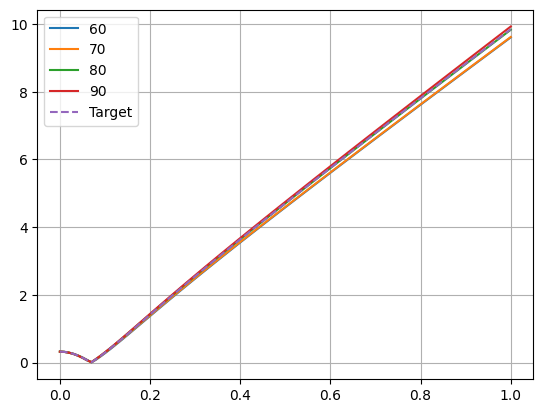

In [387]:
fig, axes = plt.subplots(); legend = []
optimizer = torch.optim.Adam([parameters], lr=0.5) # Adaptive algorithm, better
for i in range(100):
    optimizer.zero_grad()
    # f = computeError(parameters)
    f = torch.nn.MSELoss()(parameters_ideal,parameters)
    f.backward()
    optimizer.step()
    if(i%10==0 and i> 50):
        print(f'Iteration {i} : {parameters};  f = {f.item()}')
        axes.plot(w,abs(computeValues(parameters,w)).detach().numpy())
        legend.append(i)
legend.append('Target')
axes.plot(w,abs(computeValues(parameters_ideal,w)).detach().numpy(),linestyle='dashed')
print(f'Ideal parameters: {parameters_ideal}')
axes.legend(legend)
axes.grid('on')